### Slug test analysis in an unconfined aquifer

The data is taken from the [AQTESOLVE](http://www.aqtesolv.com/examples/uncslug1.htm) website. 

Butler (1998) presents results from a slug test in a partially penetrating well that is screened in unconsolidated alluvial deposits consisting of sand and gravel with interbedded clay. The aquifer has a thickness $H=47.87$ m. The depth to the top of the well screen is 16.7 m, and the screen of the well is 1.52 m long. The radius of the well is 0.125 m, and the radius of the casing is 0.064 m. The slug displacement is 0.671 m. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin
import pandas as pd
from ttim import *

In [2]:
# problem definitions
rw = 0.125 # well radius
rc = 0.064 # well casing radius
L = 1.52   # screen length
zbot = -47.87  # aquifer thickness
welltop = -16.77  # top of screen
delh = 0.671 # slug displacement in the well
#
wellbot = welltop - L  # bottom of screen
Q = np.pi * rc**2 * delh # volume of slug

In [3]:
# loading data
data = np.loadtxt('data/slugtest.txt') # time and drawdouwn
time, dd = data[:,0], data[:,1]
td = time/60/60/24 #time in days
print('minimum and maximum time:', td.min(), td.max())

minimum and maximum time: 1.1574074074074074e-06 0.004107638888888889


In [4]:
dd

array([0.663, 0.664, 0.656, 0.656, 0.656, 0.656, 0.653, 0.649, 0.649,
       0.649, 0.645, 0.642, 0.653, 0.648, 0.642, 0.638, 0.63 , 0.627,
       0.619, 0.619, 0.616, 0.608, 0.605, 0.596, 0.59 , 0.587, 0.579,
       0.568, 0.56 , 0.553, 0.539, 0.531, 0.517, 0.501, 0.486, 0.469,
       0.45 , 0.435, 0.413, 0.39 , 0.368, 0.346, 0.321, 0.295, 0.273,
       0.244, 0.221, 0.191, 0.166, 0.14 , 0.118, 0.099, 0.081, 0.059,
       0.051, 0.037, 0.025, 0.019, 0.014, 0.008, 0.008])

Flow is simulated with a quasi three-dimensional model consisting of `Nlayers` mode layers. The top and bottom of the aquifer are impermeable.
The horizontal hydraulic conductivity $k$ and elastic storage $S_s$ are unkonwn. Phreatic storage and vertical anisotropy are not simulated. The variable `p` contains the two unknown parameters. The well is modeled with the `Well` element. The type is specified as `slug`, adn the initially displaced volume is specified as $Q$. 

In [5]:
ml = Model3D(kaq=100, z=[0, -0.5, welltop, wellbot, zbot],
             Saq=1e-4, kzoverkh=1, tmin=1e-6, tmax=0.01) 
w = Well(ml, xw=0, yw=0, rw=rw, tsandQ=[(0.0, -Q)],
         layers=2, rc=rc, wbstype='slug')
ml.solve()
print('k:', ml.aq.kaq)
print('T: ', ml.aq.T)
print('c: ', ml.aq.c)
cal = Calibrate(ml)
cal.set_parameter(name='kaq0_3', initial=10)
cal.set_parameter(name='Saq0_3', initial=1e-3)
cal.series(name='obs1', x=0, y=0, layer=2, t=td, h=dd)
cal.fit()
print('k:', ml.aq.kaq)
print('T: ', ml.aq.T)
print('c: ', ml.aq.c)

self.neq  1
solution complete
k: [100. 100. 100. 100.]
T:  [  50. 1627.  152. 2958.]
c:  [1.000e+100 8.385e-002 8.895e-002 1.555e-001]
.............................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 61
    # variables        = 2
    chi-square         = 4.9814e-04
    reduced chi-square = 8.4430e-06
    Akaike info crit   = -710.645966
    Bayesian info crit = -706.424219
[[Variables]]
    kaq0_3:  6.03116199 +/- 0.02473245 (0.41%) (init = 10)
    Saq0_3:  2.1695e-04 +/- 1.0782e-05 (4.97%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0_3, Saq0_3) = -0.652
k: [6.03116199 6.03116199 6.03116199 6.03116199]
T:  [  3.015581    98.12700562   9.16736623 178.40177173]
c:  [1.00000000e+100 1.39027935e+000 1.47484017e+000 2.57827596e+000]


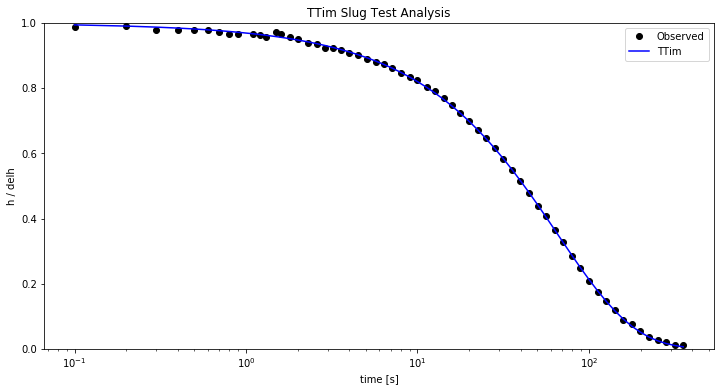

In [6]:
hm = ml.head(0, 0, td, layers=2)
plt.figure(figsize=(12, 6))
plt.semilogx(time, dd / delh, 'ko', label='Observed')
plt.semilogx(time, hm[0] / delh, 'b', label='TTim')
plt.ylim([0, 1])
plt.xlabel('time [s]')
plt.ylabel('h / delh')
plt.legend(loc='best')
plt.title('TTim Slug Test Analysis');

In [7]:
r = pd.DataFrame(columns=['Kr [m/day]','Ss [1/m]'],
                 index=['TTim', 'AQTESOLV'])
r.loc['TTim'] = cal.parameters['optimal'].values
r.loc['AQTESOLV'] = [4.034, 0.000384]
r

,Kr [m/day],Ss [1/m]
TTim,6.03116,0.000216951
AQTESOLV,4.034,0.000384


### Verify with fmin

In [8]:
def sse(p, returnheads=False):
    ml = Model3D(kaq=p[0], z=[0, -0.5, welltop, wellbot, zbot],
                 Saq=p[1], kzoverkh=1, tmin=1e-6, tmax=0.01)  
    w = Well(ml, xw=0, yw=0, rw=rw, tsandQ=[(0.0, -Q)],
             layers=2, rc=rc, wbstype='slug')
    ml.solve(silent = '.')
    hm = ml.head(0, 0, td, 2)
    if returnheads: return hm
    se = np.sum((hm[0] - dd)**2)
    return se

In [9]:
popt = fmin(sse, [3, 1e-4])
print('optimal parameters:', popt)
print('sse:', sse(popt))

.......................................................................................Optimization terminated successfully.
         Current function value: 0.000497
         Iterations: 40
         Function evaluations: 87
optimal parameters: [6.03379199e+00 2.15056769e-04]
.sse: 0.0004971940749116752
